<a href="https://colab.research.google.com/github/hgKang02/BuildMyPortfolio/blob/main/build_my_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Portfolio Overview


1. Retreive the user's portfolio(store as json?)

2. Use Markoweitz Model for Data Visualisation

3. Assess risk factor. Find data base or model to tag stocks

4. RL start with given user portfolio


#import libraries


In [ ]:
! pip install yfinance
! pip install pandas_datareader
! pip install get-all-tickers
! pip install YahooFinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for get-all-tickers: filename=get_all_tickers-1.8-py3-none-any.whl size=4247 sha256=5e969b5a46427484804f79200a86aabf407f5456d60a97de7f1b0ae064f02906
  Stored in directory: /root/.cache/pip/wheels/ca/d0/7d/7cbb7c19dc3b20b205bff412d6db0d81180ceceb07bd9d4ba8
Successfully built get-all-tickers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for YahooFinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28643 sha256=a2fe3b59547145c77d466d2510cb05a40

In [ ]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import numpy as np
from get_all_tickers import get_tickers as gt
import yfinance as yf
from yahoofinancials import YahooFinancials as yaf


# Retrieve data on existing portfolio


In [ ]:
from google.colab import drive
import json
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def is_valid(portfolio):
  sum = 0
  for idx in portfolio['ticker']:
    sum += portfolio["ratio"][idx]

  assert(sum == 1)

In [ ]:
with open('/content/gdrive/MyDrive/portfolio/portfolio.json') as json_file:
    portfolio = json.load(json_file)

print(portfolio)

#portfolio = {"ticker":{"0":"ATVI","1":"ZEUS","2":"PEP","3":"GTLB"},"ratio":{"0":0.1,"1":0.3,"2":0.45,"3":0.15}}
is_valid(portfolio)

{'ticker': {'0': 'AAPL', '1': 'TSLA', '2': 'AMZN'}, 'ratio': {'0': 0.3, '1': 0.5, '2': 0.2}}


# Retreive data using yahoo finance


get stocks of tickers and categorise into 4 categories
(slow growers, stalwarts, fast growers, asset) using a Classification model

Use 10 stock tickers for each category to train the model. 10 stocks are chosen upon expert's opinion and general concensus

Based on Peter Lynch's 6 categories of Stocks. Excluded turnarounds and Asset opportunities since it is difficult to find out without looking at the Financial Statements

Data fields needed : Price, Volume, Dividends, Stock Splits, Growth rate, PEG, ROE, Industry

1. Slow Growers : Slow growers are those stocks that have a slow growth rate(1~4%) but gives decent dividends

-

2. Stalwarts : Large well-established company that still offers long-term growth potential. Earning growth (10% ~ 12%) -> PEG lower than 1(underrated)

-

3. Fast Growers : Generally aggressive companies and they grow at an impressive rate of 15-25% per year.

-

4. Cyclicals : Stocks that grow at a very fast pace during their favorable economic cycle

-


Data for one Ticker

In [ ]:
def inputTick() :
  ticker = input("input the STOCKCODE in Yahoo Finance form(ex. 'AAPL') : ").strip().split("'")[1].upper()
  return ticker

In [ ]:
def checkTicker(tick) :
  data = yf.Ticker(tick)
  data = data.history(period=('7y'))

  if data.size == 0 :
    print('Invalid ticker')

    #ticker = inputTick()
    #checkTicker(ticker)
    return
  else :
    #data.info()
    return data

# Update Portfolio

- 티커와 금액이 주어졌을 때 포트폴리오로 저장

In [ ]:
file_path = '/content/gdrive/MyDrive/portfolio/portfolio.json'
#original = portfolio = {"ticker":{"0":"ATVI","1":"ZEUS","2":"PEP","3":"GTLB"},"ratio":{"0":0.1,"1":0.3,"2":0.45,"3":0.15}}
portfolio = {"ticker":{"0":"AAPL","1":"TSLA","2":"AMZN"},"ratio":{"0":0.3,"1":0.5,"2":0.2}}
with open(file_path, 'w') as f:
  json.dump(portfolio, f)
f.close()

FileNotFoundError: ignored

In [ ]:
with open(file_path, 'r') as f:
  pf_data = json.load(f) # dictionary
f.close()

def read_portfolio(pf_data):
  ticks = []
  ratio = []
  for idx in pf_data['ticker']:
    ticks.append(pf_data['ticker'][idx])
    ratio.append(pf_data['ratio'][idx])
  return ticks, ratio

ticks, ratio = read_portfolio(pf_data)

In [ ]:
import pandas as pd
df = pd.DataFrame({'ticker':ticks, 'ratio':ratio})
df

In [ ]:
df_name = 'past_portfolio.json'
df.to_json(df_name)

# Ticker into dataframe



- Build a random portfolio according with the dataset that is classified above.

pandas -> last column will be the classification lable.

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
base = "https://finance.yahoo.com"
sub = "/most-active"

In [ ]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36"+\
                  " (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"}

In [ ]:
def scrape_history():
  html = requests.get(base+sub, headers=headers, timeout=30)
  soup = BeautifulSoup(html.text, 'lxml')
  for tr in soup.find_all("tr", {'class': 'simpTblRow Bgc($hoverBgColor):h BdB Bdbc($seperatorColor) Bdbc($tableBorderBlue):h H(32px) Bgc($lv2BgColor)'}):
    link = tr.find('a')['href']
    q = link.split('?')
    q = q[0]+'/history?'+'period1=1277769600&period2=1679616000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
    html = requests.get(base+q, headers=headers, timeout=30)
    soup = BeautifulSoup(html.text, 'lxml')

In [ ]:
def scrape_stats(url):
  html = requests.get(url, headers=headers, timeout=30)
  soup = BeautifulSoup(html.text, 'lxml')
  # PEG
  for row in soup.find_all("tr", {"class": "Bxz(bb) H(36px) BdB Bdbc($seperatorColor) fi-row Bgc($hoverBgColor):h"}):
    if "PEG" in row.find("td").text:
      peg = row.find(class_="Ta(c) Pstart(10px) Miw(60px) Miw(80px)--pnclg Bgc($lv1BgColor) fi-row:h_Bgc($hoverBgColor)").text
      break
  # ROE
  for row in soup.find_all("tr", {"class": "Bxz(bb) H(36px) BdB Bdbc($seperatorColor)"}):
    if "Return on Equity" in row.find("td").text:
      roe = row.find(class_="Fw(500) Ta(end) Pstart(10px) Miw(60px)").text
      roe = roe[:-1]
      return peg, roe

In [ ]:
def scrape_industry(url, ticker):
  html = requests.get(url, headers=headers, timeout=30)
  soup = BeautifulSoup(html.text, 'lxml')
  for row in soup.find_all("tr", {"class": "data-rowTSLA Bgc($hoverBgColor):h BdT Bdc($seperatorColor) Bdc($tableBorderBlue):h H(33px)"}):
    if ticker == row.find("td").text:
      industry = row.find(class_="data-col3 Ta(start) Pstart(20px) Miw(60px)").text
      return industry

In [ ]:
def scrape_by_tick(tick):
  base = "https://finance.yahoo.com/quote/"
  lookup_base = "https://finance.yahoo.com/lookup?s="
  profile_url = lookup_base + tick
  stats_url = base + tick + "/key-statistics?p=" + tick
  #industry = scrape_industry(profile_url, tick)
  peg, roe = scrape_stats(stats_url)
  return peg, roe

In [ ]:
def tickToDF(ticker) :
  data = checkTicker(ticker)
  dividends = pd.Series(data['Dividends'])
  dividend = 0.0
  if (data['Dividends'].nunique() > 1):
    dividend = dividends[dividends[dividends != 0.0].index[-1]]
  print(type(dividend))
  # peg, roe = scrape_by_tick(ticker)
  extra_features = np.array([[dividend]])
  # extra_features = np.append(extra_features)
  #extra_features = dividend
  data = data.reset_index().drop(['Date','Dividends', 'Stock Splits'],axis=1)
  return data, extra_features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def tickToDFDate(ticker) :
  data = checkTicker(ticker)
  dividends = pd.Series(data['Dividends'])
  dividend = 0.0
  if (data['Dividends'].nunique() > 1):
    dividend = dividends[dividends[dividends != 0.0].index[-1]]
  print(type(dividend))
  # peg, roe = scrape_by_tick(ticker)
  extra_features = np.array([[dividend]])
  # extra_features = np.append(extra_features)
  #extra_features = dividend
  data = data.reset_index().drop(['Dividends', 'Stock Splits'],axis=1)
  return data, extra_features

In [ ]:
#ticker = input("Plug in the ticker that you want: ")
#data, extra_features = tickToDF(ticker)
#print(extra_features)
#extra_features
#data.head()

# Training data for Classification model

In [ ]:
# SG = Slow growers, SW = Stalwarts, FG = Fast Growers, CY = Cyclicals
train = {'SG' : ["AAPL", "CL", "MSFT", "BLK", "CME", "MA", "PFG", "V", "RES", "GE"],
         'SW' : ["INTC", "CHD", "XOM", "PG", "MCD", "KMB", "JNJ", "MMM", "T", "FDX"],
         'FG' : ["TSLA", "GOOG", "CPRX", "AMZN", "AMGN", "META", "GOOGL", "NVDA", "SHOP", "ROKU"],
         'CY' : ["DAL", "COST", "AA", "NKE", "JWN", "TGT", "SBUX", "DIS", "F", "HD"]}

In [ ]:
label_dict = {'SG':0 ,'SW':1, 'FG':2, 'CY':3}

## go through train dictionary to build a df

In [ ]:
train_dict = {}
for k, v in train.items():
  for tick in v :
    t = tick
    data, extra_features = tickToDF(t)
    train_dict[tick] = [data, extra_features, k]

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'float'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


# Stock Classification model

In [ ]:
# train_dict {ticker : [dataframe, extra_features(np.array), label]}
#example : meta
print(len(train_dict))
print(train_dict['META'])

40
[                          Date        Open        High         Low  \
0    2016-05-02 00:00:00-04:00  117.830002  118.730003  116.570000   
1    2016-05-03 00:00:00-04:00  117.519997  118.160004  117.019997   
2    2016-05-04 00:00:00-04:00  116.610001  118.300003  116.570000   
3    2016-05-05 00:00:00-04:00  118.040001  118.980003  117.250000   
4    2016-05-06 00:00:00-04:00  117.160004  119.639999  117.110001   
...                        ...         ...         ...         ...   
1757 2023-04-25 00:00:00-04:00  210.820007  211.259995  207.130005   
1758 2023-04-26 00:00:00-04:00  212.500000  214.110001  208.880005   
1759 2023-04-27 00:00:00-04:00  239.889999  241.690002  236.770004   
1760 2023-04-28 00:00:00-04:00  239.009995  240.429993  235.750000   
1761 2023-05-01 00:00:00-04:00  238.615005  244.000000  236.460007   

           Close    Volume  
0     118.570000  28095200  
1     117.430000  24117500  
2     118.059998  23448400  
3     117.809998  22056700  
4     119.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for tick in train_dict:
  # scaler = MinMaxScaler()
  # train_dict[tick][0] = scaler.fit_transform(train_dict[tick][0])
  train_dict[tick][0] = train_dict[tick][0].to_numpy()

In [ ]:
for tick in train_dict:
  train_dict[tick][0] = torch.Tensor(train_dict[tick][0])
  # x = x.permute(1,0)
  train_dict[tick][0] = train_dict[tick][0].unsqueeze(0)


TypeError: ignored

In [ ]:
for tick in train_dict:
  train_dict[tick][-1] = torch.LongTensor([label_dict[train_dict[tick][-1]]])
  # train_dict[tick][-1] = torch.nn.functional.one_hot(torch.LongTensor([label_dict[train_dict[tick][-1]]]), num_classes=len(label_dict))
  # x = x.permute(1,0)
  # train_dict[tick][-1] = train_dict[tick][-1].unsqueeze(0)


In [ ]:
train_dict[tick][-1].size()

torch.Size([1])

In [ ]:
class LSTM_classifier(nn.Module):
  def __init__(self, embed_dim, out_dim, device='cpu', dropout=0.2):
    super(LSTM_classifier, self).__init__()
    self.out_dim = out_dim
    self.device = device
    self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=out_dim, dropout = dropout, batch_first=True)
    self.fc1 = nn.Linear(out_dim, 32)

  def forward(self, x):
    h0 = Variable(torch.zeros(x.size(0), 1, self.out_dim)).to(self.device)
    c0 = Variable(torch.zeros(x.size(0), 1, self.out_dim)).to(self.device)
    _, (hn, cn) = self.lstm(x, (h0, c0))
    output = F.relu(self.fc1(hn))
    return output

In [ ]:
class Classifier(nn.Module):
  def __init__(self, embed_dim, out_dim, device='cpu', dropout=0.2):
    super(Classifier, self).__init__()
    self.open_lstm = LSTM_classifier(embed_dim, out_dim, device, dropout)
    self.high_lstm = LSTM_classifier(embed_dim, out_dim, device, dropout)
    self.low_lstm = LSTM_classifier(embed_dim, out_dim, device, dropout)
    self.close_lstm = LSTM_classifier(embed_dim, out_dim, device, dropout)

In [ ]:
embed_dim = 5
out_dim = 32
device = 'cpu'
model = LSTM_classifier(embed_dim, out_dim, device, dropout=0.2)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
optimizer = SGD(model.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, optimizer, criterion, train_dict, epoch = 10, device='cpu'):
  model = model.to(device)
  for i in range(epoch):
    epoch_loss = 0
    for tick in tqdm(train_dict):
      x = train_dict[tick][0]
      y = train_dict[tick][-1]
      x = x.to(device)
      y = y.to(device)

      optimizer.zero_grad()
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()

      epoch_loss += loss
    print(f"EPOCH {i+1} total: {epoch_loss}, avg: {epoch_loss/len(train_dict)}")


In [ ]:
train(model, optimizer, criterion, train_dict, 7, 'cpu')

  0%|          | 0/40 [00:00<?, ?it/s]


AttributeError: ignored

## Inference

In [ ]:
data, _ = tickToDF('RES')
data

In [ ]:
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
# data
data = data.to_numpy()

In [ ]:
data = torch.Tensor(data)
data = data.unsqueeze(0)
data.size()

In [ ]:
for tick in train_dict:
  pred = model(train_dict[tick][0])
  print(torch.argmax(pred, dim=1), train_dict[tick][-1])

# Markoweitz Visualisation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing
solvers.options['show_progress'] = False

In [ ]:
## NUMBER OF ASSETS
n_assets = 4
## n_assets = len(df)

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

Text(0, 0.5, 'returns')

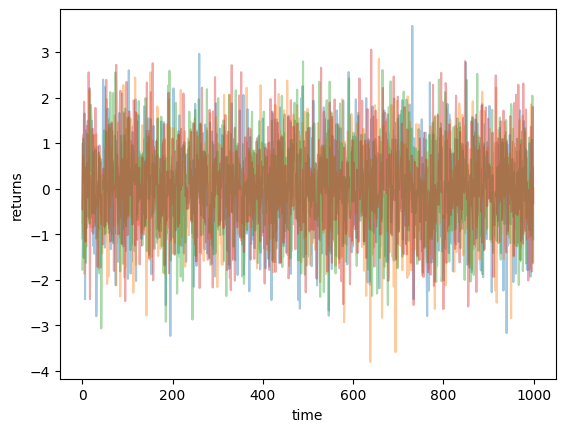

In [ ]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [ ]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [ ]:
def random_portfolio(returns):
    '''
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))

    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)

    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [ ]:
n_portfolios = 500
means, stds = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])

In [ ]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

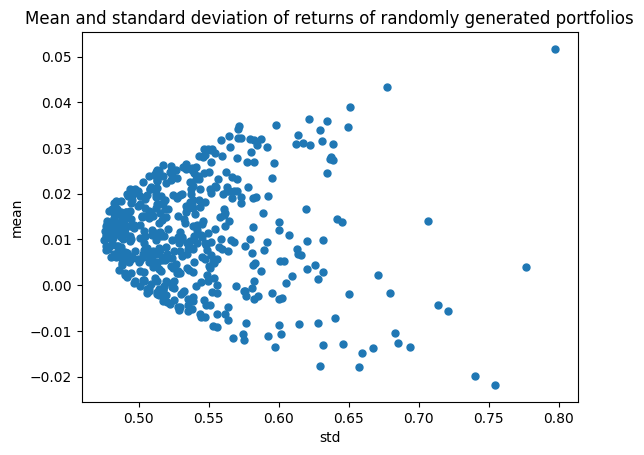

In [ ]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

## Markowitz optimization and the Efficient Frontier


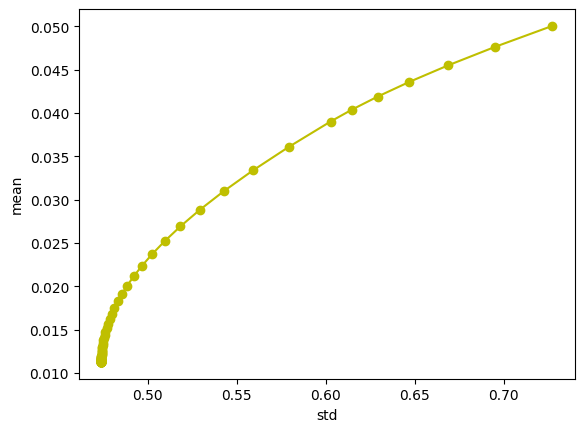

In [ ]:
weights, returns, risks = optimal_portfolio(return_vec)
#plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

# 환경 설정

1. json file을 4개의 카테고리로 나누기 -> 고성장주, 저성장주 등등
2. 그 json file로 RL environment 만들기
3. 마지막에 optimized 된 포트폴리오 다시 json으로 저장

# RL environment

##import dependencies

In [ ]:
!pip install setuptools==65.5.0
!pip install torch torchvision
!pip install stable-baselines3[extra]
!pip install gym-anytrading
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# For environment
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install Cmake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pip setuptools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached setuptools-67.7.2-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.0
    Uninstalling setuptools-65.5.0:
      Successfully uninstalled setuptools-65.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
!pip install gym==0.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached stable_baselines3-1.8.0-py3-none-any.whl (174 kB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from stable_baselines3 import PPO

ModuleNotFoundError: ignored

In [ ]:
from tabnanny import verbose
import joblib
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import glob
import pandas as pd
from stable_baselines3 import PPO

ModuleNotFoundError: ignored

## Dummy data

In [ ]:
dummy = {'SG' : ["AAPL"],
         'SW' : ["KMB"],
         'FG' : ["AMZN",],
         'CY' : ["NKE"]}

In [ ]:
dummy_dict = {}
for k, v in dummy.items():
  for tick in v :
    t = tick
    data, extra_features = tickToDFDate(t)
    dummy_dict[tick] = [data, extra_features, k]

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>


In [ ]:
dummy_dict["AAPL"]

## Multi-Stock Environment Set Up

* dfs — a list of data frames containing the raw historical data, one for each asset
* price_df — a data frame containing the historical closing prices of each stock as a column in each

* initial_amount — the initial amount invested into the model for training

* trade_cost — the cost of each trade, currently set to zero

* num_features — the number of features per time interval for each asset

* num_stocks — number of assets to be traded

* window_size — the number of previous time intervals data to be considered for the next action

* frame_bound — the range of values (start_index, end_index)in the price_df index to be used for training/test, start_index must be greater than window_size

* scalers — the list of scalers used for scaling the data for each stock, internally defined if not already provided

* tech_indicator_list — the list of technical indicators to be utilized for trading, num_features is updated if provided

* reward_scaling — scaling the rewards/profits from our trading



In [ ]:

class MultiStockTradingEnv(gym.Env):

    metadata = {"render.modes": ["human"]}

    def __init__(self,dfs,price_df,initial_amount,trade_cost,num_features,num_stocks,window_size,frame_bound,scalers=None,
        tech_indicator_list=[],reward_scaling=1e-5,suppresention_rate=0.66,representative=None):

        if len(tech_indicator_list)!=0:
            num_features = len(tech_indicator_list)
        self.dfs = dfs
        self.price_df = price_df
        self.initial_amount = initial_amount
        self.margin = initial_amount
        self.portfolio = [0]*num_stocks
        self.PortfolioValue = 0
        self.reserve = initial_amount
        self.trade_cost = trade_cost
        self.state_space = num_features
        self.assets = num_stocks
        self.reward_scaling=reward_scaling
        self.tech_indicators = tech_indicator_list
        self.window_size = window_size
        self.frame_bound = frame_bound

        # spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(num_stocks,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_stocks,window_size,num_features), dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.price_df) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = np.zeros(self.assets)
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self.rewards = []
        self.pvs = []
        if scalers == None:
            self.scalers = [None]*self.assets
        else:
            self.scalers =scalers

        self.representative = representative
        self.suppression_rate = suppresention_rate

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def process_data(self):
        signal_features = []
        for i in range(self.assets):
            df = self.dfs[i]
            start = self.frame_bound[0] - self.window_size
            end = self.frame_bound[1]
            if self.scalers[i]:
                current_scaler = self.scalers[i]
                signal_features_i = current_scaler.transform(df.loc[:, self.tech_indicators])[start:end]
            else:
                current_scaler = StandardScaler()
                signal_features_i = current_scaler.fit_transform(df.loc[:, self.tech_indicators])[start:end]
                self.scalers[i] = current_scaler
            signal_features.append(signal_features_i)

        self.prices = self.price_df.loc[:, :].to_numpy()[start:end]
        if self.representative:
            self.representative = self.price_df.loc[:, self.representative].to_numpy()[start:end]
        # else:
        #     self.representative = self.price_df.loc[:, 'SENSEX'].to_numpy()[start:end]
        self.signal_features = np.array(signal_features)
        self._end_tick = len(self.prices)-1
        return self.prices, self.signal_features

    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._end_tick = len(self.prices)-1
        self._last_trade_tick = self._current_tick - 1
        self._position = np.zeros(self.assets)
        self._position_history = (self.window_size * [None]) + [self._position]
        self.margin = self.initial_amount
        self.portfolio = [0]*self.assets
        self.PortfolioValue = 0
        self.reserve = self.initial_amount
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    def _update_profit(self, ):
        self._total_profit = (self.PortfolioValue+self.reserve)/self.initial_amount


    def step(self, actions):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        #Get the current prices
        current_prices = self.prices[self._current_tick]

        #handling cases where current price is na and avoiding buying infinite 0 cost stocks
        current_prices[np.isnan(current_prices)] = 0

        current_prices_for_division = current_prices

        current_prices_for_division[current_prices_for_division == 0] = 1e9

        #the absolute value distribution of next step portfolio
        abs_portfolio_dist = abs(actions)

        # At any point in time we only trade for 33% of the stocks the model is most confident about
        # the scores for the rest are suppressed

        N = int(np.round(abs_portfolio_dist.size*self.suppression_rate))

        abs_portfolio_dist[np.argpartition(abs_portfolio_dist,kth=N)[:N]] = 0

        self.margin = self.reserve + sum(self.portfolio*current_prices)

        #Normalize the portfolio positions for next step
        norm_margin_pos = (abs_portfolio_dist/sum(abs_portfolio_dist))*self.margin

        #Calulate the money in the next positions
        next_positions = np.sign(actions)*norm_margin_pos

        #Change in money value of the positions
        change_in_positions = next_positions - self._position

        #actions to take in the market
        actions_in_market = np.divide(change_in_positions,current_prices_for_division).astype(int)
        new_portfolio = actions_in_market + self.portfolio
        new_pv = sum(new_portfolio*current_prices)
        new_reserve = self.margin - new_pv
        profit = (new_pv + new_reserve) - (self.PortfolioValue + self.reserve)

        # calculate the cost of each action in market
        cost = self.trade_cost*sum(abs(np.sign(actions_in_market)))
        self._position = next_positions
        self.portfolio = new_portfolio
        self.PortfolioValue = new_pv
        self.reserve = new_reserve - cost

        # Calculate the total step reward - profit made this step
        step_reward = profit - cost
        self._total_reward += self.reward_scaling*step_reward
        self.rewards.append(self._total_reward)
        self.pvs.append(new_pv)
        self._update_profit()

        self._position = next_positions
        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
        )
        self._update_history(info)
        if self.margin < 0:
            self._done = True

        return observation, step_reward, self._done, info

    def _get_observation(self):
        return np.nan_to_num(self.signal_features[:,(self._current_tick-self.window_size+1):self._current_tick+1,:])

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def render(self, mode='human'):

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.pvs)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        plt.pause(0.01)

    def render_all(self, mode='human'):
        plt.plot(self.pvs)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError
    def _calculate_reward(self, action):
        raise NotImplementedError
    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

Creating the multistock environment

In [ ]:
dummy_dict["AAPL"][0].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Volume,datetime
0,2016-05-02 00:00:00-04:00,21.590693,21.615967,21.229968,21.514872,192640400,2016-05-02 00:00:00-04:00
1,2016-05-03 00:00:00-04:00,21.643531,21.997364,21.524056,21.868698,227325200,2016-05-03 00:00:00-04:00
2,2016-05-04 00:00:00-04:00,21.873295,22.034129,21.556225,21.641237,164102000,2016-05-04 00:00:00-04:00
3,2016-05-05 00:00:00-04:00,21.729079,21.745260,21.423947,21.553396,143562000,2016-05-05 00:00:00-04:00
4,2016-05-06 00:00:00-04:00,21.583446,21.601937,21.232081,21.433191,174799600,2016-05-06 00:00:00-04:00


In [ ]:
indicators = ['Open', 'High', 'Low', 'Close', 'Volume' ]

dfs = pd.DataFrame()

num_assets = 0

names = []

for k, v in dummy.items():
  for tick in v :
    df, extra_features, k = dummy_dict[tick]
    df['datetime'] = pd.to_datetime(df['Date'])
    name = k
    names.append(name)
    # Adding the Time of Day and Day of Week features
    df['ToD'] = df['datetime'].dt.hour + df['datetime'].dt.minute/60
    df['DoW'] = df['datetime'].dt.weekday/6
    df.sort_values(['datetime'], inplace=True)
    df = df.set_index(pd.DatetimeIndex(df['datetime']))
    df.drop(['datetime'], axis=1, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    dfs = pd.concat([dfs,df], axis=1)
    num_assets += 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dfs.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Volume,ToD,DoW,Date,Open,...,ToD,DoW,Date,Open,High,Low,Close,Volume,ToD,DoW
datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-02 00:00:00-04:00,2016-05-02 00:00:00-04:00,21.590693,21.615967,21.229968,21.514872,192640400,0.0,0.000000,2016-05-02 00:00:00-04:00,99.262481,...,0.0,0.000000,2016-05-02 00:00:00-04:00,54.829319,55.441729,54.736531,55.293266,8647800,0.0,0.000000
2016-05-03 00:00:00-04:00,2016-05-03 00:00:00-04:00,21.643531,21.997364,21.524056,21.868698,227325200,0.0,0.166667,2016-05-03 00:00:00-04:00,99.198902,...,0.0,0.166667,2016-05-03 00:00:00-04:00,54.968500,55.534513,54.773640,55.228310,8061300,0.0,0.166667
2016-05-04 00:00:00-04:00,2016-05-04 00:00:00-04:00,21.873295,22.034129,21.556225,21.641237,164102000,0.0,0.333333,2016-05-04 00:00:00-04:00,100.112997,...,0.0,0.333333,2016-05-04 00:00:00-04:00,54.959232,55.636595,54.578795,54.847885,8062800,0.0,0.333333
2016-05-05 00:00:00-04:00,2016-05-05 00:00:00-04:00,21.729079,21.745260,21.423947,21.553396,143562000,0.0,0.500000,2016-05-05 00:00:00-04:00,101.662976,...,0.0,0.500000,2016-05-05 00:00:00-04:00,54.690131,54.727247,53.817911,53.994209,7846000,0.0,0.500000
2016-05-06 00:00:00-04:00,2016-05-06 00:00:00-04:00,21.583446,21.601937,21.232081,21.433191,174799600,0.0,0.666667,2016-05-06 00:00:00-04:00,101.345045,...,0.0,0.666667,2016-05-06 00:00:00-04:00,53.966375,54.226185,53.242618,54.216908,7308000,0.0,0.666667


In [ ]:
dfs.interpolate(method='pad', limit_direction='forward', inplace=True)

print(dfs.columns)

cols_per_asset = int(len(dfs.columns)/num_assets)

df_list = []
price_df = pd.DataFrame()

for i in range(num_assets):
    df = dfs.iloc[:,i*cols_per_asset:i*cols_per_asset+cols_per_asset]
    #print(df.columns)
    df.drop(['Date'], axis=1, inplace=True)
    price_df[names[i]] = df['Close']
    df_list.append(df)

cols_per_asset -= 1

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ToD', 'DoW', 'Date',
       'Open', 'High', 'Low', 'Close', 'Volume', 'ToD', 'DoW', 'Date', 'Open',
       'High', 'Low', 'Close', 'Volume', 'ToD', 'DoW', 'Date', 'Open', 'High',
       'Low', 'Close', 'Volume', 'ToD', 'DoW'],
      dtype='object')


In [ ]:
len(df_list)

4

In [ ]:
#def __init__(self, dfs, price_df, initial_amount, trade_cost, num_features, num_stocks, window_size, frame_bound, scalers=None, tech_indicator_list=[], reward_scaling=1e-5):

## Initialising the instance of env

In [ ]:
env = MultiStockTradingEnv(df_list,
        price_df,
        num_stocks=num_assets,
        initial_amount=1000000,
        trade_cost=0,
        num_features=cols_per_asset,
        window_size=12,
        frame_bound = (12,len(price_df)-1500),
        tech_indicator_list=indicators)

prices, features = env.process_data()

## PPO model

In [ ]:
model = PPO('MlpPolicy', env, verbose=2,tensorboard_log='tb_logs', batch_size=256)
model.learn(total_timesteps=1000)

In [ ]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.savefig('rewards.jpg')
name="MultiStockTrader"
model.save("saved_models/"+name)
scalers = env.scalers

## Result

In [ ]:
prices, features = env.process_data()
obs = env.reset()
count=0
total_rewards = 0
infer_rewards = []
while True:
        # obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        count+=1
        obs, rewards, done, info = env.step(action)
        print(action, rewards)
        total_rewards += rewards

        infer_rewards.append(rewards)
        if done:
                print("info", count,info)
                break

print("Total profit: \n", sum(infer_rewards))

infer_steps = price_df.index[len(price_df)-len(infer_rewards):len(price_df)]#np.array(list(range(len(infer_rewards))))
infer_rewards = np.cumsum(np.array(infer_rewards))

#sensex_values = env.representative[-len(infer_steps):]

plt.title(name)
plt.plot(infer_steps, infer_rewards, color="red", label='Profit')
# plt.plot(infer_steps, sensex_values, color="blue", label='Index')
plt.legend(loc="upper left")
plt.savefig('Infer_rewards.jpg')